<a href="https://colab.research.google.com/github/DiegoArgn/QM-2/blob/main/QM_updated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Method Overview
**Objective**: This study examines the relationship between gambling expenditure and labour market conditions in Australia, focusing on unemployment rates across eight regions and at the national level. The analysis proceeds in two stages:

**Panel regression** to identify robust **correlations** while controlling for unobserved regional heterogeneity.

**Granger causality analysis** to examine lead–lag dynamics and temporal **causation**.

This two-step approach allows the study to separate contemporaneous association from dynamic predictive causality.

# 1. Data
**1.1 Unit of Analysis**

Cross-sectional unit: Australian regions $i = ACT, NSW, \dots, WA$

Time unit: annual observations $t=1,\dots,T$

Balanced panel: each region observed over the same time span

**1.2 Key Variables**

*  Dependent or independent relies on the test direction

*  $Gambling_t^{(i)}$ : real per-capita gambling expenditure $(\$)$

*  $Unemp_t^{(i)}$ : regional unemployment rate $(\%)$

**1.3 Transformations**

$Gambling_t^{(i)} → ln(Gambling_t^{(i)})$

**1.4 Control variables ($X_t^{(i)}$):**

Quarterly Population Estimates (Persons)

Wage price index

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels.panel import PanelOLS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.1 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving QM2.csv to QM2.csv


In [3]:
# Read data
df = pd.read_csv('QM2.csv')
df.head()

,State,Year,Real per capita total gambling expenditure value (AU$),Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $),Average Week Earnings (AU$),Quarterly Population Estimates (Persons),Wage price index
0,ACT,1998–99,1739.17,6.00,11739.0,690.15,312917.25,69.25
1,ACT,1999–00,1757.75,5.04,12528.0,730.90,316057.50,70.98
2,ACT,2000–01,1761.04,4.58,12807.0,754.80,319771.00,73.50
3,ACT,2001–02,1718.74,4.52,13462.0,721.55,323407.50,75.80
4,ACT,2002–03,1723.14,4.26,14253.0,789.85,326411.25,78.40


In [4]:
# Convert year columns
df.dropna(subset=['Year'], inplace=True)
df['year'] = df['Year'].str[-2:].astype(int) + 2000
df.loc[df['year'] > 2025, 'year'] -= 100
df

,State,Year,Real per capita total gambling expenditure value (AU$),Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $),Average Week Earnings (AU$),Quarterly Population Estimates (Persons),Wage price index,year
0,ACT,1998–99,1739.17,6.00,11739.0,690.15,312917.25,69.25,1999
1,ACT,1999–00,1757.75,5.04,12528.0,730.90,316057.50,70.98,2000
2,ACT,2000–01,1761.04,4.58,12807.0,754.80,319771.00,73.50,2001
3,ACT,2001–02,1718.74,4.52,13462.0,721.55,323407.50,75.80,2002
4,ACT,2002–03,1723.14,4.26,14253.0,789.85,326411.25,78.40,2003
...,...,...,...,...,...,...,...,...,...
203,WA,2019–20,787.04,6.02,126209.0,1372.15,2695576.75,132.48,2020
204,WA,2020–21,971.28,6.09,129351.0,1400.50,2734164.50,134.43,2021
205,WA,2021–22,946.83,3.81,137505.0,1462.20,2772794.50,137.35,2022
206,WA,2022–23,925.11,3.56,144880.0,1532.65,2853711.00,142.58,2023


In [5]:
# Relabel the columns
STATE = "State"
YEAR  = "year"
GAMB  = "Real per capita total gambling expenditure value (AU$)"
UNEMP = "Unemployment rate (%)"
WPI   = "Wage price index"
POP   = "Quarterly Population Estimates (Persons)"

# Keep only necessary columns
df = df[[STATE, YEAR, GAMB, UNEMP, WPI, POP]].copy()

# Ensure numeric data of all variables
df[[GAMB, UNEMP, WPI, POP]] = df[[GAMB, UNEMP, WPI, POP]].apply(
    pd.to_numeric, errors="coerce"
)

# Log gambling (must be > 0)
df = df[df[GAMB] > 0]
df["log_gambling"] = np.log(df[GAMB])

# Log controls (must be > 0)
df = df[df[POP] > 0]
df["log_pop"] = np.log(df[POP])

# Drop missing and set panel index
df = df.dropna(subset=[STATE, YEAR, "log_gambling", UNEMP, WPI, "log_pop"])
df = df.set_index([STATE, YEAR]).sort_index()

df


Real per capita total gambling expenditure value (AU$)  \
State year                                                           
ACT   1999                                            1739.17        
      2000                                            1757.75        
      2001                                            1761.04        
      2002                                            1718.74        
      2003                                            1723.14        
...                                                       ...        
WA    2020                                             787.04        
      2021                                             971.28        
      2022                                             946.83        
      2023                                             925.11        
      2024                                             896.41        

            Unemployment rate (%)  Wage price index  \
State year                                            
ACT   1999                   6.00             69.25   
      2000                   5.04             70.98   
      2001                   4.58             73.50   
      2002                   4.52             75.80   
      2003                   4.26             78.40   
...                           ...               ...   
WA    2020                   6.02            132.48   
      2021                   6.09            134.43   
      2022                   3.81            137.35   
      2023                   3.56            142.58   
      2024                   3.73            148.85   

            Quarterly Population Estimates (Persons)  log_gambling    log_pop  
State year                                                                     
ACT   1999                                 312917.25      7.461163  12.653694  
      2000                                 316057.50      7.471790  12.663679  
      2001                                 319771.00      7.473660  12.675360  
      2002                                 323407.50      7.449347  12.686668  
      2003                                 326411.25      7.451903  12.695913  
...                                              ...           ...        ...  
WA    2020                                2695576.75      6.668279  14.807123  
      2021                                2734164.50      6.878615  14.821336  
      2022                                2772794.50      6.853120  14.835366  
      2023                                2853711.00      6.829913  14.864131  
      2024                                2948666.75      6.798398  14.896864  

[208 rows x 6 columns]

# 3. Models
# 3.1 Time-series OLS + Panel Regression
**3.1.A Model A: Gambling leads unemployment**

*   Test of gambling → later unemployment




**Model A1: National time-series OLS (Australia as a whole)**

$$
Unemp_t
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\varepsilon_t
$$

**Model A2: Single-region time-series OLS** (e.g. NSW only)

* Same equation - just applied to one region.

$$
Unemp_{i,t}
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{i,t-k})
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\varepsilon_{i,t}
$$

\begin{align}
H_0 &: \beta_0 = \beta_1 = \cdots = \beta_p = 0
&& \text{(Gambling expenditure has no association with unemployment)} \\
H_1 &: \exists \; k \in \{0,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Gambling expenditure is associated with unemployment at some lag)}
\end{align}

Both two times series OLS test for “Does gambling correlate with later unemployment within this specific region over time?”

In [6]:
def ts_ols_modelA(ts_df, *, year_col=YEAR, p=1):

    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    # Lag gambling INCLUDING contemporaneous term (k = 0)
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d["log_gambling"].shift(k)

    rhs = (
        [f"g_L{k}" for k in range(0, p + 1)]
        + [ "log_pop", WPI]
    )

    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": p}
    )

    return res, d


In [7]:
#Call National level
df_flat = df.reset_index()

nat = (
    df_flat
    .groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
    .mean()
    .reset_index()
)

res_nat, used_nat = ts_ols_modelA(nat, year_col=YEAR, p=5)
print(res_nat.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.566
Model:                               OLS   Adj. R-squared:                  0.276
Method:                    Least Squares   F-statistic:                     50.89
Date:                   Sat, 10 Jan 2026   Prob (F-statistic):           4.29e-08
Time:                           15:08:24   Log-Likelihood:                -12.544
No. Observations:                     21   AIC:                             43.09
Df Residuals:                         12   BIC:                             52.49
Df Model:                              8                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [8]:
# Call National level Exclude Northern Territory
df_flat_noNT = df_flat[df_flat["State"] != "NT"].copy()
# National series excluding NT (average across remaining states)
nat_noNT = (
    df_flat_noNT
    .groupby(YEAR)[[UNEMP, "log_gambling","log_pop", WPI]]
    .mean()
    .reset_index()
)

res_nat_noNT, used_nat_noNT = ts_ols_modelA(
    nat_noNT,
    year_col=YEAR,
    p=5
)

print(res_nat_noNT.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.854
Model:                               OLS   Adj. R-squared:                  0.757
Method:                    Least Squares   F-statistic:                     534.4
Date:                   Sat, 10 Jan 2026   Prob (F-statistic):           4.01e-14
Time:                           15:08:24   Log-Likelihood:                -2.4470
No. Observations:                     21   AIC:                             22.89
Df Residuals:                         12   BIC:                             32.29
Df Model:                              8                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [9]:
#Call Regional level
region_nsw = df_flat[df_flat["State"] == "NSW"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

res_nsw, used_nsw = ts_ols_modelA(region_nsw, year_col=YEAR, p=3)
print(res_nsw.summary())

                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.683
Model:                               OLS   Adj. R-squared:                  0.564
Method:                    Least Squares   F-statistic:                     39.74
Date:                   Sat, 10 Jan 2026   Prob (F-statistic):           9.81e-09
Time:                           15:08:24   Log-Likelihood:                -11.301
No. Observations:                     23   AIC:                             36.60
Df Residuals:                         16   BIC:                             44.55
Df Model:                              6                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [10]:
# MAKE ONE RESULT TABLE (National, 8 states, National excl NT) ======

from statsmodels.iolib.summary2 import summary_col
import numpy as np
import pandas as pd

# ---------- helpers ----------
def cumulative_gambling_effect(res, p):
    return sum(float(res.params.get(f"g_L{k}", 0.0)) for k in range(0, p + 1))

def wald_pvalue_gambling_raw(res, p):
    terms = [f"g_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)  # scalar=True avoids FutureWarning
    return float(wt.pvalue)

def format_p(pval, decimals=6):
    # raw numeric p-value, formatted consistently; if extremely tiny, show scientific
    if pval == 0.0:
        return "0"
    if pval < 10**(-decimals):
        return f"{pval:.2e}"
    return f"{pval:.{decimals}f}"

# ---------- settings ----------
P = 5   # lag length used in ts_ols_modelA (must match your estimation)
EXCL = "NT"      # exclude NT for the robustness national series

# ---------- flatten panel ----------
df_flat = df.reset_index()

# ---------- National (All) ----------
nat_all = (
    df_flat.groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_all, _ = ts_ols_modelA(nat_all, year_col=YEAR, p=P)

# ---------- State models ----------
state_models, state_names = [], []
for st in sorted(df_flat["State"].dropna().unique()):
    sub = df_flat[df_flat["State"] == st][
        [YEAR, UNEMP, "log_gambling",  "log_pop", WPI]
    ]
    res, _ = ts_ols_modelA(sub, year_col=YEAR, p=P)
    state_models.append(res)
    state_names.append(st)

# ---------- National (exclude NT) ----------
nat_excl = (
    df_flat[df_flat["State"] != EXCL]
    .groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_excl, _ = ts_ols_modelA(nat_excl, year_col=YEAR, p=P)

# ---------- build summary_col table ----------
models = [model_nat_all] + state_models + [model_nat_excl]
names  = ["National (All)"] + state_names + [f"National (excl {EXCL})"]

regressor_order = (
    ["const"]
    + [f"g_L{k}" for k in range(0, P + 1)]
    + [ "log_pop", WPI]
)

# Keep info_dict minimal to avoid duplicated lines
table = summary_col(
    models,
    stars=True,
    float_format="%0.3f",
    model_names=names,
    regressor_order=regressor_order,
    info_dict={
        "N": lambda x: f"{int(x.nobs)}"
    },
)

# ---------- append extra rows (aligned as normal rows) ----------
df_table = table.tables[0]

cum_vals = [f"{cumulative_gambling_effect(m, P):.3f}" for m in models]
wald_vals = [format_p(wald_pvalue_gambling_raw(m, P), decimals=6) for m in models]

df_table.loc[f"Cumulative gambling effect (sum g_L0..g_L{P})"] = cum_vals
df_table.loc[f"Wald p-value (H0: g_L0..g_L{P} = 0)"] = wald_vals

# ---------- print in a “parallel” aligned way (avoid wrapping) ----------
with pd.option_context(
    "display.width", 4000,
    "display.max_columns", None,
    "display.max_colwidth", None
):
    print(df_table.to_string())


                                            National (All)         ACT        NSW          NT        QLD         SA        TAS        VIC         WA National (excl NT)
const                                              725.721  553.047***    -55.272  533.570***    147.688    789.113     55.346     10.928    796.812          990.281**
                                                 (717.544)    (85.084)  (108.640)   (157.723)  (260.661)  (487.017)  (155.228)  (117.044)  (680.663)          (407.397)
g_L0                                             -1.260***    1.464***      1.357      -0.182   -1.158**  -3.290***     -2.476   -1.268**     -3.051          -4.053***
                                                   (0.439)     (0.485)    (1.705)     (0.121)    (0.574)    (0.428)    (1.786)    (0.598)    (4.257)            (0.701)
g_L1                                             -2.078***      1.562*  -8.784***    0.206***  -6.164***  -4.570***  -4.347***    1.162**      0.240          -6

In [11]:
# ---------- Sensitivity test over lag length p ----------

P_MAX = 14   # or whatever maximum lag you want

rows = []

for p in range(0, P_MAX + 1):

    # run NATIONAL model (example: national average series)
    res, used = ts_ols_modelA(nat_all, year_col=YEAR, p=p)

    # cumulative effect
    cum_eff = cumulative_gambling_effect(res, p)

    # Wald test
    terms = [f"g_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)

    rows.append({
        "p": p,
        "Cumulative gambling effect": cum_eff,
        "Wald stat (H0: g_L0..g_Lp = 0)": float(wt.statistic),
        "Wald p-value (H0: g_L0..g_Lp = 0)": float(wt.pvalue),
        "N": int(res.nobs),
    })

# build table
sens_table = pd.DataFrame(rows).set_index("p")

# pretty print
with pd.option_context(
    "display.float_format", "{:.6g}".format,
    "display.width", 2000
):
    print(sens_table)


    Cumulative gambling effect  Wald stat (H0: g_L0..g_Lp = 0)  Wald p-value (H0: g_L0..g_Lp = 0)   N
p                                                                                                    
0                     -1.09264                         1.25781                           0.262067  26
1                     -1.36604                         1.33709                           0.512453  25
2                     -0.12796                         25.6423                        1.13322e-05  24
3                     0.680044                         39.3145                        5.99841e-08  23
4                      1.66115                         57.1993                        4.60058e-11  22
5                     -3.20993                         251.995                        1.53657e-51  21
6                    0.0311666                         1088.92                       7.31992e-231  20
7                      3.78098                         16534.1                    

**Intepret the Coefficient**

Note: Here I deliberately set $k$ starting from $0$, so that when $k=0$ we capture the contemporaneous effect, that is, how unemployment and gambling move within the same year.

Updated: I've included the cumulative gambling effect row and Wald p-value to help the analysis.

**Model A3: 8-region panel** (main regional analysis)

$$
Unemp_t
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\mu_i
+\lambda_t
+\eta_{i,t}
$$

\begin{align}
H_0 &: \sum_{k=0}^{p}\theta_k = 0,
&& k = 0,1,\dots,p
&& \text{(No overall association over the lag window)} \\
H_1 &: \sum_{k=0}^{p}\theta_k \neq 0,
&& k = 0,1,\dots,p
&& \text{(Overall association over the lag window)}
\end{align}


**Note:** We only use panel regression when we have both **cross-sectional** and **time-series** data. In this case, it only works when we include all 8 regions together with their time-series data.

In the previous section, I use time-series OLS because we do not use the cross-sectional dimension and instead examine one region at a time.


Panel model tells “Within regions, does gambling lead unemployment **after accounting for regional differences and national shocks?**”

**The error terms**

**$\bf 1. \; \mu^{(i)}$ :** Region fixed effects $:=$ everything about that region that does NOT change over time

“Controls for things that make $NSW$ permanently different from $WA$.”

Examples: Cultural attitudes toward gambling, Long-run industry structure (e.g. mining-heavy $WA$), Historical labour-market characteristics, etc.

These factors differ across regions but are constant over time within each region.

**$\bf 2. \; \lambda_t$ :** Year fixed effects $:=$ everything that affects all regions in year

“Controls for things that affect all regions in a given year, like COVID.”

Examples: National recessions / booms, COVID, Interest-rate cycles, etc.

So if unemployment and gambling both spike in 2020: that variation is absorbed by 𝜆 not attributed to gambling causing unemployment

**$\bf 3. \; \epsilon_t^{(i)}$ :** Idiosyncratic shocks $:=$ unexpected region-year noise

“Everything else we can't explain.”

Examples: A local factory closure, A temporary regional event, Measurement error, etc.

In [12]:
def panel_fe_modelA(df_panel, *, p=1):
    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Required columns
    required = [UNEMP, "log_gambling", "log_pop", WPI]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns in df_panel: {missing}")

    # Build gambling lags within state: k = 0..p
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d.groupby(level=0)["log_gambling"].shift(k)

    # Regressors: gambling lags + controls
    g_terms = [f"g_L{k}" for k in range(0, p + 1)]
    rhs = g_terms + ["log_pop", WPI]

    # Drop missing due to lags
    d = d[[UNEMP] + rhs].dropna()

    y = d[UNEMP].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)

    # Cumulative effect: sum_{k=0..p} beta_k
    cum_effect = float(res.params[g_terms].sum())

    # Joint Wald test: H0: g_L0 = ... = g_Lp = 0
    param_names = list(res.params.index)
    K = len(param_names)
    R = np.zeros((len(g_terms), K))
    for i, term in enumerate(g_terms):
        R[i, param_names.index(term)] = 1.0
    q = np.zeros(len(g_terms))

    wald = res.wald_test(R, q)
    wald_stat = float(wald.stat)
    wald_pval = float(wald.pval)

    extra = pd.DataFrame(
        {
            "Cumulative gambling effect": [cum_effect],
            "Wald stat (H0: g_L0..g_Lp = 0)": [wald_stat],
            "Wald p-value (H0: g_L0..g_Lp = 0)": [wald_pval],
            "N": [int(res.nobs)],
            "p": [int(p)],
        }
    )

    return res, extra



In [13]:
# ---- HOW TO CALL THE PANEL (choose one p) ----
# Example: run the panel with p = 3
res_panel, extra_panel = panel_fe_modelA(df, p=3)

# regression output
print(res_panel.summary)

# diagnostics as separate rows (vertical)
print(extra_panel.T.rename(columns={0: "value"}))

                            PanelOLS Estimation Summary                            
Dep. Variable:     Unemployment rate (%)   R-squared:                        0.2041
Estimator:                      PanelOLS   R-squared (Between):             -9.3769
No. Observations:                    184   R-squared (Within):              -6.9619
Date:                   Sat, Jan 10 2026   R-squared (Overall):             -9.3013
Time:                           15:08:24   Log-likelihood                   -128.76
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      6.3252
Entities:                              8   P-value                           0.0000
Avg Obs:                          23.000   Distribution:                   F(6,148)
Min Obs:                          23.000                                           
Max Obs:                          23.000   F-statistic (robust):            

In [14]:
#PART 2 — Sensitivity test over multiple p
def sensitivity_test_panelA(df_panel, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]):
    rows = []

    for p in p_list:
        _, extra = panel_fe_modelA(df_panel, p=p)
        rows.append(extra)

    out = pd.concat(rows, ignore_index=True).set_index("p")
    return out

In [15]:
# ---- HOW TO CALL THE SENSITIVITY TEST ----
# Example: test p = 1..5
sens = sensitivity_test_panelA(df, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
sens

,Cumulative gambling effect,Wald stat (H0: g_L0..g_Lp = 0),Wald p-value (H0: g_L0..g_Lp = 0),N
p,,,,
0,-0.201524,1.957323e+00,1.617999e-01,208
1,-0.245929,3.010211e+01,2.906767e-07,200
2,-0.306728,5.114539e+01,4.555323e-11,192
3,-0.264158,4.846175e+01,7.561316e-10,184
4,-0.067288,4.929585e+01,1.930758e-09,176
5,0.039482,6.272892e+01,1.253453e-11,168
6,-0.052636,2.174210e+02,0.000000e+00,160
7,0.078024,6.166975e+14,0.000000e+00,152
8,0.491003,2.059171e+15,0.000000e+00,144


**3.1.B Model B: Gambling lags unemployment**

Test of unemployment → later gambling




This part should be really easy to understand if you understand 3.1.A, we are just switching the dependent and independent variables.
Therefore, I'll simplify the explanation ;)



**Model B1 and B2: Time-series OLS run at National and Regional level**

$$
\ln(Gambling_{i,t})
=
\alpha
+\sum_{k=0}^{p}\theta_k\,Unemp_{i,t-k}
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\varepsilon_{i,t}
$$

\begin{align}
H_0 &: \beta_0 = \beta_1 = \cdots = \beta_p = 0,
\qquad k \in \{0,1,\dots,p\}
&& \text{(Gambling expenditure has no association with unemployment)} \\
H_1 &: \exists\, k \in \{0,1,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Gambling expenditure is associated with unemployment over the lag window)}
\end{align}


In [16]:
# Model B (time-series OLS): log_gambling_t on lags of unemployment + controls (log_awe, log_pop, WPI)

def ts_ols_modelB(ts_df, *, year_col=YEAR, p=1):
    """
    log_gambling_t ~ u_{t}, u_{t-1}, ..., u_{t-p} + log_awe_t + log_pop_t + WPI_t
    HAC (Newey–West) SEs with maxlags = p
    """

    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    # Lag unemployment: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [17]:
# Call Model B1
# National
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]].mean().reset_index()

res_nat_B, used_nat_B = ts_ols_modelB(nat, year_col=YEAR, p=5)# change p here
print(res_nat_B.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     42.61
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           1.19e-07
Time:                        15:08:26   Log-Likelihood:                 28.723
No. Observations:                  21   AIC:                            -39.45
Df Residuals:                      12   BIC:                            -30.04
Df Model:                           8                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               60.6754     42.150  

In [18]:
#Call Model B2
# Regional
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", "log_pop", WPI]] # change region here

res_nsw_B, used_nsw_B = ts_ols_modelB(region, year_col=YEAR, p=3)# change p here
print(res_nsw_B.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     4.375
Date:                Sat, 10 Jan 2026   Prob (F-statistic):            0.00841
Time:                        15:08:26   Log-Likelihood:                 36.156
No. Observations:                  23   AIC:                            -58.31
Df Residuals:                      16   BIC:                            -50.36
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6466     26.062  

In [19]:
# ========= MODEL B RESULTS TABLE (National + 8 states + National excl NT)


# ---- helpers ----
def cumulative_unemp_effect(res, p):
    return sum(float(res.params.get(f"u_L{k}", 0.0)) for k in range(0, p + 1))

def wald_pvalue_unemp_block(res, p):
    terms = [f"u_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)  # avoids FutureWarning
    return float(wt.pvalue)

def fmt_p(pval, decimals=6):
    # raw p-value, readable (scientific if very small)
    if pval == 0.0:
        return "0"
    if pval < 10**(-decimals):
        return f"{pval:.2e}"
    return f"{pval:.{decimals}f}"

# ---- settings ----
P = 5       # set lag length here (e.g., 3 if you want u_L0..u_L3)
EXCL = "NT"    # exclude NT for robustness national series

# ---- flatten ----
df_flat = df.reset_index()

# ---- National (All) ----
nat_all = (
    df_flat.groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_all, _ = ts_ols_modelB(nat_all, year_col=YEAR, p=P)

# ---- Each state ----
state_models, state_names = [], []
for st in sorted(df_flat["State"].dropna().unique()):
    sub = df_flat[df_flat["State"] == st][
        [YEAR, UNEMP, "log_gambling",  "log_pop", WPI]
    ]
    res, _ = ts_ols_modelB(sub, year_col=YEAR, p=P)
    state_models.append(res)
    state_names.append(st)

# ---- National (exclude NT) ----
nat_excl = (
    df_flat[df_flat["State"] != EXCL]
    .groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_excl, _ = ts_ols_modelB(nat_excl, year_col=YEAR, p=P)

# ---- Build table ----
models = [model_nat_all] + state_models + [model_nat_excl]
names  = ["National (All)"] + state_names + [f"National (excl {EXCL})"]

regressor_order = (
    ["const"]
    + [f"u_L{k}" for k in range(0, P + 1)]
    + [ "log_pop", WPI]
)

table = summary_col(
    models,
    stars=True,
    float_format="%0.3f",
    model_names=names,
    regressor_order=regressor_order,
    info_dict={
        "R-squared": lambda x: f"{x.rsquared:.3f}",
        "R-squared Adj.": lambda x: f"{x.rsquared_adj:.3f}",
        "N": lambda x: f"{int(x.nobs)}",
    },
)

# ---- Append extra rows ----
df_table = table.tables[0]

cum_vals  = [f"{cumulative_unemp_effect(m, P):.3f}" for m in models]
wald_pvals = [fmt_p(wald_pvalue_unemp_block(m, P), decimals=6) for m in models]

df_table.loc[f"Cumulative unemployment effect (sum u_L0..u_L{P})"] = cum_vals
df_table.loc[f"Wald p-value (H0: u_L0..u_L{P} = 0)"] = wald_pvals

# ---- Print aligned ----
with pd.option_context("display.width", 4000, "display.max_columns", None, "display.max_colwidth", None):
    print(df_table.to_string())


                                                National (All)         ACT       NSW         NT        QLD         SA        TAS       VIC        WA National (excl NT)
const                                                   60.675  -64.015***   58.888*  -147.379*   63.458**      5.738     -7.756    31.174   -43.529          76.307***
                                                      (42.150)    (20.356)  (32.142)   (88.193)   (25.874)   (58.603)   (13.881)  (25.985)  (32.082)           (28.562)
u_L0                                                   -0.053*    -0.085**   -0.040*      0.050  -0.040***  -0.081***  -0.056***  -0.139**    -0.018          -0.070***
                                                       (0.030)     (0.042)   (0.021)    (0.117)    (0.015)    (0.024)    (0.018)   (0.058)   (0.017)            (0.013)
u_L1                                                     0.031       0.050   0.035**      0.012     -0.004     -0.004     -0.038    0.044*    -0.018            

In [20]:
# ---------- Sensitivity test over lag length p ----------

P_MAX = 14   # or whatever maximum lag you want

rows = []

for p in range(0, P_MAX + 1):

    # run NATIONAL model (example: national average series)
    res, used = ts_ols_modelB(nat_all, year_col=YEAR, p=p)

    # cumulative effect (using the correct function for unemployment lags)
    cum_eff = cumulative_unemp_effect(res, p)

    # Wald test (using the correct function for unemployment lags)
    # The function wald_pvalue_unemp_block expects the model results and p
    wald_p_val = wald_pvalue_unemp_block(res, p)

    # To get the statistic, we need to manually reconstruct the Wald test as wald_pvalue_unemp_block only returns p-value
    terms = [f"u_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)
    wald_stat = float(wt.statistic)

    rows.append({
        "p": p,
        "Cumulative unemployment effect": cum_eff,
        "Wald stat (H0: u_L0..u_Lp = 0)": wald_stat,
        "Wald p-value (H0: u_L0..u_Lp = 0)": wald_p_val,
        "N": int(res.nobs),
    })

# build table
sens_table = pd.DataFrame(rows).set_index("p")

# pretty print
with pd.option_context(
    "display.float_format", lambda x: f"{x:.6g}",
    "display.width", 2000
):
    print(sens_table)

    Cumulative unemployment effect  Wald stat (H0: u_L0..u_Lp = 0)  Wald p-value (H0: u_L0..u_Lp = 0)   N
p                                                                                                        
0                       -0.0125865                         1.34593                            0.24599  26
1                     -0.000328669                        0.641511                           0.725601  25
2                       -0.0030995                         1.49345                           0.683782  24
3                      -0.00768354                         11.5746                           0.020812  23
4                         -0.02557                         9.81755                          0.0805731  22
5                       -0.0530935                         37.1272                        1.66316e-06  21
6                       -0.0898598                         123.601                         1.3614e-23  20
7                        -0.126313            

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  warnings.warn('covariance of constraints does not have full '


**Model B3: 8-region panel**

$$
\ln(Gambling_{i,t})
=
\alpha
+\sum_{k=0}^{p}\theta_k\,Unemp_{i,t-k}
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\mu_i
+\lambda_t
+\eta_{i,t}
$$

\begin{align}
H_0 &: \sum_{k=0}^{p}\theta_k = 0,
&& k = 0,1,\dots,p
&& \text{(No overall association over the lag window)} \\
H_1 &: \sum_{k=0}^{p}\theta_k \neq 0,
&& k = 0,1,\dots,p
&& \text{(Overall association over the lag window)}
\end{align}

In [21]:
# Model B (panel FE): log_gambling on lags of unemployment + controls (log_awe, log_pop, WPI)

def panel_modelB(df_panel, *, p=1):


    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Lags of unemployment within state: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    # Regressors: unemployment lags + controls
    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [ "log_pop", WPI]

    # Keep complete cases
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    return mod.fit(cov_type="clustered", cluster_entity=True)


In [22]:
# call panel
resB_panel = panel_modelB(df, p=5)
print(resB_panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.2896
Estimator:                   PanelOLS   R-squared (Between):             -2.7141
No. Observations:                 168   R-squared (Within):              -1.1889
Date:                Sat, Jan 10 2026   R-squared (Overall):             -2.7120
Time:                        15:08:27   Log-likelihood                    25.638
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7274
Entities:                           8   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(8,132)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):           1.16e+14
                            

In [23]:
# =========================
# PART 1 — Panel FE Model B (reverse direction)
#   log_gambling_{i,t} on unemployment lags + controls
#   + cumulative effect + joint Wald test
# =========================

import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

def panel_fe_modelB(df_panel, *, p=1):
    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Required columns
    required = ["log_gambling", UNEMP, "log_pop", WPI]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns in df_panel: {missing}")

    # Lags of unemployment within state: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    # Regressors: unemployment lags + controls
    u_terms = [f"u_L{k}" for k in range(0, p + 1)]
    rhs = u_terms + ["log_pop", WPI]

    # Keep complete cases (lags induce N drop)
    d = d[["log_gambling"] + rhs].dropna()

    y = d["log_gambling"].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)

    # ---- Cumulative effect: sum_{k=0..p} theta_k ----
    cum_effect = float(res.params[u_terms].sum())

    # ---- Joint Wald test: H0: u_L0 = ... = u_Lp = 0 ----
    param_names = list(res.params.index)
    K = len(param_names)
    R = np.zeros((len(u_terms), K))
    for i, term in enumerate(u_terms):
        R[i, param_names.index(term)] = 1.0
    q = np.zeros(len(u_terms))

    wald = res.wald_test(R, q)
    wald_stat = float(wald.stat)
    wald_pval = float(wald.pval)

    extra = pd.DataFrame(
        {
            "Cumulative unemployment effect": [cum_effect],
            "Wald stat (H0: u_L0..u_Lp = 0)": [wald_stat],
            "Wald p-value (H0: u_L0..u_Lp = 0)": [wald_pval],
            "N": [int(res.nobs)],
            "p": [int(p)],
        }
    )

    return res, extra

In [24]:
# ---- HOW TO CALL THE PANEL (choose one p) ----
# Example: run Model B panel with p = 3
resB_panel, extraB_panel = panel_fe_modelB(df, p=3)

print(resB_panel.summary)
print(extraB_panel.T.rename(columns={0: "value"}))

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.1729
Estimator:                   PanelOLS   R-squared (Between):             -2.1199
No. Observations:                 184   R-squared (Within):               0.0043
Date:                Sat, Jan 10 2026   R-squared (Overall):             -2.1170
Time:                        15:08:27   Log-likelihood                    14.568
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.1554
Entities:                           8   P-value                           0.0001
Avg Obs:                       23.000   Distribution:                   F(6,148)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             356.43
                            

In [25]:
# =========================
# PART 2 — Sensitivity test for Panel Model B over multiple p
# =========================

def sensitivity_test_panelB(df_panel, p_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)):
    rows = []
    for p in p_list:
        _, extra = panel_fe_modelB(df_panel, p=p)
        rows.append(extra)

    out = pd.concat(rows, ignore_index=True).set_index("p")
    return out

In [26]:
# ---- HOW TO CALL THE SENSITIVITY TEST ----
# Example: test p = 1..5
sensB = sensitivity_test_panelB(df, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
sensB

,Cumulative unemployment effect,Wald stat (H0: u_L0..u_Lp = 0),Wald p-value (H0: u_L0..u_Lp = 0),N
p,,,,
0,-0.035314,6.699461e+00,0.009644,208
1,-0.082635,9.281755e+00,0.009649,200
2,-0.140037,2.807882e+01,0.000003,192
3,-0.201275,2.848143e+01,0.000010,184
4,-0.241942,9.869362e+01,0.000000,176
5,-0.281432,2.399212e+02,0.000000,168
6,-0.343093,1.110597e+02,0.000000,160
7,-0.411345,-2.273773e+13,1.000000,152
8,-0.523271,3.566694e+14,0.000000,144


All of the models in Section 3.1 only provide information about **correlation**. To further examine whether a **causal** relationship exists, we employ Granger causality analysis.

What “Granger causality” actually means is not philosophical causality. Instead, it asks a specific and testable question:

Do past values of gambling improve our ability to predict unemployment, over and above unemployment’s own past values?

If yes, gambling is said to Granger-cause unemployment.

But the good news is that Granger causality is much simpler than Section 3.1, where we used combined OLS and panel regression. For the panel analysis, we use the same equation and model structure for both national-level and regional-level data, and we simply switch the dependent and independent variables.

# 3.2 Conditional Granger causality tests

3.2.C Model C: Gambling Granger-causes unemployment
* supports gambling leads unemployment

$$
Unemp_t
=
\alpha
+\sum_{k=1}^{p}\gamma_k\,Unemp_{t-k}
+\sum_{k=1}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\epsilon_t
$$

**Hypothesis**:


\begin{align}
H_0 &: \beta_1 = \beta_2 = \cdots = \beta_p = 0
&& \text{(Lagged gambling has no predictive content for unemployment)} \\
H_1 &: \exists\, k \in \{1,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Lagged gambling has predictive content for unemployment)}
\end{align}

In [27]:
def granger_gambling_to_unemp_joint(
    ts_df,
    *,
    year_col=YEAR,
    maxlag=4,
    controls=("log_pop", WPI)
):
    def stars(p):
        if p < 0.01:
            return "***"
        if p < 0.05:
            return "**"
        if p < 0.1:
            return "*"
        return ""

    cols = [year_col, UNEMP, "log_gambling", *controls]
    d = ts_df[cols].dropna().sort_values(year_col).copy()

    rows = []

    for L in range(1, maxlag + 1):
        tmp = d.copy()

        # build lags
        for k in range(1, L + 1):
            tmp[f"u_L{k}"] = tmp[UNEMP].shift(k)
            tmp[f"g_L{k}"] = tmp["log_gambling"].shift(k)

        tmp = tmp.dropna()

        y = tmp[UNEMP].astype(float)

        X = sm.add_constant(
            tmp[[f"u_L{k}" for k in range(1, L + 1)] +
                [f"g_L{k}" for k in range(1, L + 1)] +
                list(controls)]
            .astype(float)
        )

        res = sm.OLS(y, X).fit()

        # joint F-test: all gambling lags = 0
        param_names = list(X.columns) # Re-adding this line
        # Fix: R should have L+1 rows to test g_L0, ..., g_LL
        # Note: Granger causality typically tests only for lagged effects (k=1 to L), not contemporaneous (k=0).
        # The current R definition and loop range for k (1 to L) correctly reflect this.
        R = np.zeros((L, len(param_names))) # Changed back to L rows because `k` goes from 1 to L, so we test L parameters.
        for i, k in enumerate(range(1, L + 1)): # k starts from 1, so indices in R will be 0 to L-1
            R[i, param_names.index(f"g_L{k}")] = 1.0

        ftest = res.f_test(R)

        # cumulative direction
        cum_coef = sum(res.params[f"g_L{k}"] for k in range(1, L + 1))

        rows.append({
            "Lag": L,
            "Cumulative gambling effect": cum_coef,
            "Direction": "Positive" if cum_coef > 0 else "Negative",
            "F_stat": float(ftest.fvalue),
            "p_value": float(ftest.pvalue),
            "N": int(res.nobs)
        })

    return pd.DataFrame(rows)

In [28]:
#national
gc_nat = granger_gambling_to_unemp_joint(
    nat_all,
    year_col=YEAR,
    maxlag=7
)
print(gc_nat)


   Lag  Cumulative gambling effect Direction    F_stat   p_value   N
0    1                    0.437768  Positive  0.094208  0.762067  25
1    2                    2.831183  Positive  4.920045  0.020614  24
2    3                    2.075466  Positive  5.397357  0.011155  23
3    4                    2.391649  Positive  5.497764  0.011103  22
4    5                   -0.508097  Negative  3.883495  0.043962  21
5    6                    4.887083  Positive  1.710599  0.286152  20
6    7                  -10.221503  Negative  0.635912  0.727135  19


In [29]:
#regional
# Corrected: Use .isin() for selecting multiple states
region = df_flat[df_flat["State"] == "QLD"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

gc_nsw = granger_gambling_to_unemp_joint(
    region,
    year_col=YEAR,
    maxlag=5
)
print(gc_nsw)

   Lag  Cumulative gambling effect Direction     F_stat   p_value   N
0    1                   -8.385117  Negative  31.564902  0.000017  25
1    2                  -10.269181  Negative  12.999854  0.000375  24
2    3                  -20.138952  Negative  16.369293  0.000075  23
3    4                  -20.637227  Negative   7.976675  0.002854  22
4    5                  -20.235937  Negative   4.350112  0.032844  21


3.2.D Model D2: Unemployment Granger-causes gambling
* supports gambling lags unemployment

$$
\ln(Gambling_t)
=
\alpha
+\sum_{k=1}^{p}\phi_k\,\ln(Gambling_{t-k})
+\sum_{k=1}^{p}\theta_k\,Unemp_{t-k}
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\eta_t
$$

\begin{align}
H_0 &: \theta_1 = \theta_2 = \cdots = \theta_p = 0
&& \text{(Lagged unemployment has no predictive content for gambling)} \\
H_1 &: \exists\, k \in \{1,\dots,p\} \text{ such that } \theta_k \neq 0
&& \text{(Lagged unemployment has predictive content for gambling)}
\end{align}

In [30]:
def granger_unemp_to_gambling_joint(
    ts_df,
    *,
    year_col=YEAR,
    maxlag=4,
    controls=( "log_pop", WPI)
):

    cols = [year_col, UNEMP, "log_gambling", *controls]
    d = ts_df[cols].dropna().sort_values(year_col).copy()

    rows = []

    for L in range(1, maxlag + 1):
        tmp = d.copy()

        # build lags
        for k in range(1, L + 1):
            tmp[f"g_L{k}"] = tmp["log_gambling"].shift(k)
            tmp[f"u_L{k}"] = tmp[UNEMP].shift(k)

        tmp = tmp.dropna()

        y = tmp["log_gambling"].astype(float)

        X = sm.add_constant(
            tmp[[f"g_L{k}" for k in range(1, L + 1)] +
                [f"u_L{k}" for k in range(1, L + 1)] +
                list(controls)]
            .astype(float)
        )

        res = sm.OLS(y, X).fit()

        # joint F-test: all unemployment lags = 0
        param_names = list(X.columns)
        R = np.zeros((L, len(param_names)))
        for i, k in enumerate(range(1, L + 1)):
            R[i, param_names.index(f"u_L{k}")] = 1.0

        ftest = res.f_test(R)

        # cumulative direction
        cum_coef = sum(res.params[f"u_L{k}"] for k in range(1, L + 1))

        rows.append({
            "Lag": L,
            "Cumulative unemployment effect": cum_coef,
            "Direction": "Positive" if cum_coef > 0 else "Negative",
            "F_stat": float(ftest.fvalue),
            "p_value": float(ftest.pvalue),
            "N": int(res.nobs)
        })

    return pd.DataFrame(rows)


In [31]:
gd_nat = granger_unemp_to_gambling_joint(
    nat_all,
    year_col=YEAR,
    maxlag=5
)
print(gd_nat)


   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N
0    1                        0.010825  Positive  0.196174  0.662581  25
1    2                        0.015762  Positive  0.159809  0.853572  24
2    3                        0.006906  Positive  0.361098  0.782052  23
3    4                        0.006983  Positive  0.135050  0.966005  22
4    5                       -0.170249  Negative  0.434956  0.812861  21


In [32]:
region = df_flat[df_flat["State"] == "TAS"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

gd_nsw = granger_unemp_to_gambling_joint(
    region,
    year_col=YEAR,
    maxlag=5
)
print(gd_nsw)


   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N
0    1                       -0.054994  Negative  4.960121  0.037587  25
1    2                       -0.044113  Negative  0.821952  0.456302  24
2    3                       -0.067403  Negative  1.114190  0.376527  23
3    4                       -0.195851  Negative  1.362224  0.308642  22
4    5                       -0.214709  Negative  0.727359  0.622223  21


To summarise, we have two parts in our method.

Part $1$ tests for correlation using time-series OLS (national and regional) and panel regression (national).

Part $2$ tests for causation using Granger causality (national and regional).

Please tell me anything you think may be we should add or delete:), also here are some things to think about:


I am thinking about may be choose one from Times-series OLS at the national level and panel regression at the national level, maybe we should subtract the OLS at national level?


In [33]:
#national
gc_nat = granger_gambling_to_unemp_joint(
    nat_all,
    year_col=YEAR,
    maxlag=5
)
print(gc_nat)


   Lag  Cumulative gambling effect Direction    F_stat   p_value   N
0    1                    0.437768  Positive  0.094208  0.762067  25
1    2                    2.831183  Positive  4.920045  0.020614  24
2    3                    2.075466  Positive  5.397357  0.011155  23
3    4                    2.391649  Positive  5.497764  0.011103  22
4    5                   -0.508097  Negative  3.883495  0.043962  21


/tmp/ipython-input-3930612038.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Lag', y='p_value', data=gc_nat, palette='viridis', marker='o', legend=False)


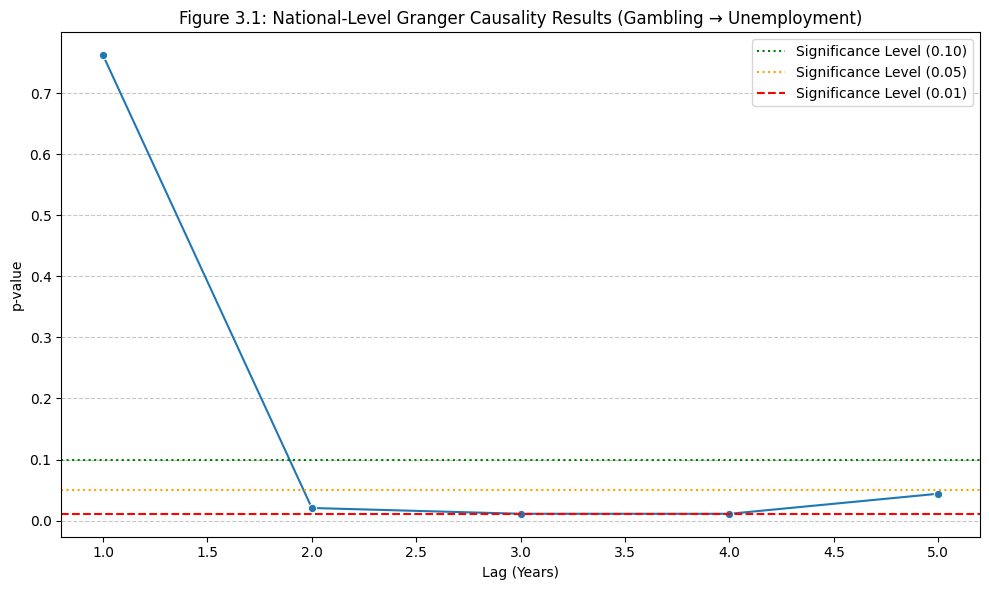

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a line plot for gc_nat p-values
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lag', y='p_value', data=gc_nat, palette='viridis', marker='o', legend=False)

plt.axhline(0.10, color='green', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')
plt.title('Figure 3.1: National-Level Granger Causality Results (Gambling → Unemployment)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
gd_nat = granger_unemp_to_gambling_joint(
    nat_all,
    year_col=YEAR,
    maxlag=5
)
print(gd_nat)


   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N
0    1                        0.010825  Positive  0.196174  0.662581  25
1    2                        0.015762  Positive  0.159809  0.853572  24
2    3                        0.006906  Positive  0.361098  0.782052  23
3    4                        0.006983  Positive  0.135050  0.966005  22
4    5                       -0.170249  Negative  0.434956  0.812861  21


/tmp/ipython-input-679472077.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Lag', y='p_value', data=gd_nat, palette='viridis', marker='o', legend=False)


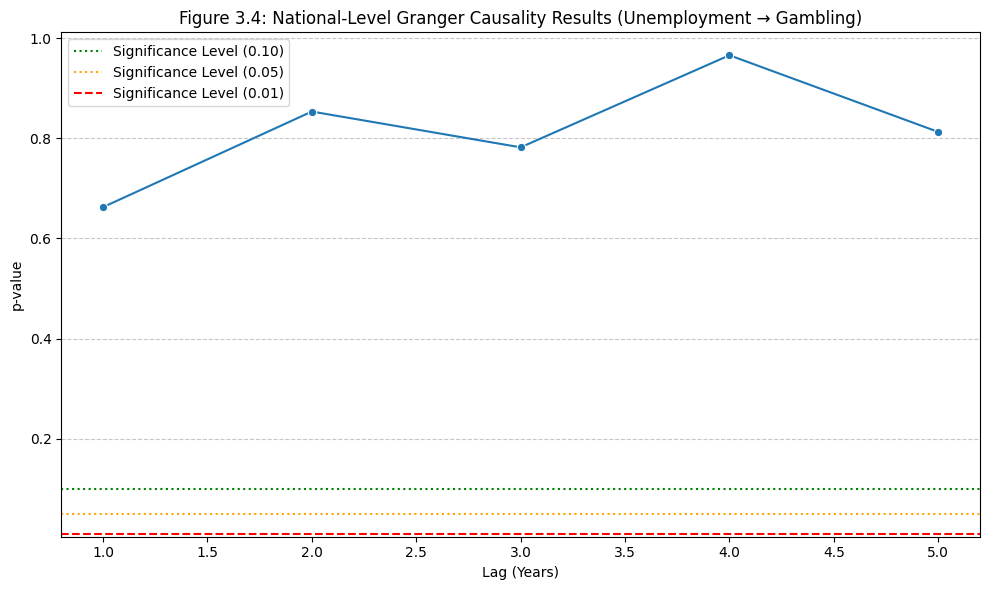

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a line plot for gd_nat p-values (national level)
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lag', y='p_value', data=gd_nat, palette='viridis', marker='o', legend=False)
plt.axhline(0.10, color='green', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')
plt.title('Figure 3.4: National-Level Granger Causality Results (Unemployment → Gambling)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
unique_states = df_flat['State'].dropna().unique()

all_regional_gc_results = []

for state_name in unique_states:
    region_df = df_flat[df_flat["State"] == state_name][
        [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
    ]
    gc_result = granger_gambling_to_unemp_joint(
        region_df,
        year_col=YEAR,
        maxlag=5
    )
    gc_result['Region'] = state_name
    all_regional_gc_results.append(gc_result)




In [46]:
combined_gc_all_regions = pd.concat(all_regional_gc_results, ignore_index=True)
print(combined_gc_all_regions.head())

   Lag  Cumulative gambling effect Direction    F_stat   p_value   N Region
0    1                   -0.825935  Negative  1.362711  0.256798  25    ACT
1    2                   -1.089121  Negative  0.802534  0.464462  24    ACT
2    3                    0.352775  Positive  1.184941  0.351059  23    ACT
3    4                   -0.534187  Negative  1.681865  0.223702  22    ACT
4    5                   -6.213784  Negative  1.813738  0.216366  21    ACT


In [47]:
significant_regions_gc = []
non_significant_regions_gc = []

unique_regions = combined_gc_all_regions['Region'].unique()

for region in unique_regions:
    region_data = combined_gc_all_regions[combined_gc_all_regions['Region'] == region]
    # Check if any p_value for this region is less than 0.05
    if (region_data['p_value'] < 0.05).any():
        significant_regions_gc.append(region)
    else:
        non_significant_regions_gc.append(region)

print(f"Significant Regions (Gambling -> Unemployment, p < 0.05): {significant_regions_gc}")
print(f"Non-Significant Regions (Gambling -> Unemployment, p < 0.05): {non_significant_regions_gc}")

Significant Regions (Gambling -> Unemployment, p < 0.05): ['NSW', 'QLD', 'SA']
Non-Significant Regions (Gambling -> Unemployment, p < 0.05): ['ACT', 'NT', 'TAS', 'VIC', 'WA']


In [48]:
combined_gc_all_regions = pd.concat(all_regional_gc_results, ignore_index=True)
print(combined_gc_all_regions.head())

   Lag  Cumulative gambling effect Direction    F_stat   p_value   N Region
0    1                   -0.825935  Negative  1.362711  0.256798  25    ACT
1    2                   -1.089121  Negative  0.802534  0.464462  24    ACT
2    3                    0.352775  Positive  1.184941  0.351059  23    ACT
3    4                   -0.534187  Negative  1.681865  0.223702  22    ACT
4    5                   -6.213784  Negative  1.813738  0.216366  21    ACT


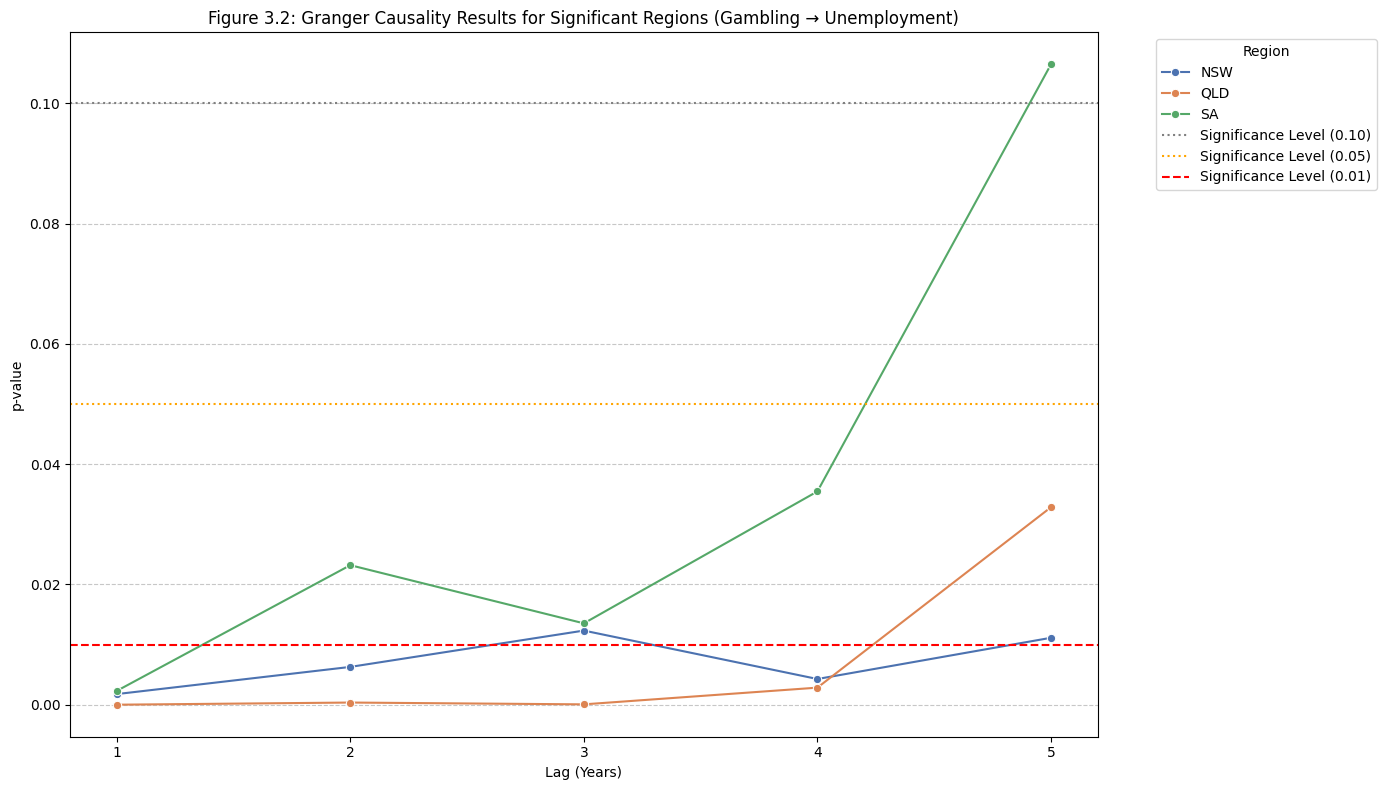

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the combined_gc_all_regions DataFrame for significant regions
significant_gc_df = combined_gc_all_regions[combined_gc_all_regions['Region'].isin(significant_regions_gc)]

plt.figure(figsize=(14, 8))
sns.lineplot(x='Lag', y='p_value', hue='Region', data=significant_gc_df, marker='o', palette='deep')

plt.axhline(0.10, color='grey', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')

plt.title('Figure 3.2: Granger Causality Results for Significant Regions (Gambling → Unemployment)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(significant_gc_df['Lag'].unique())
plt.tight_layout()
plt.show()

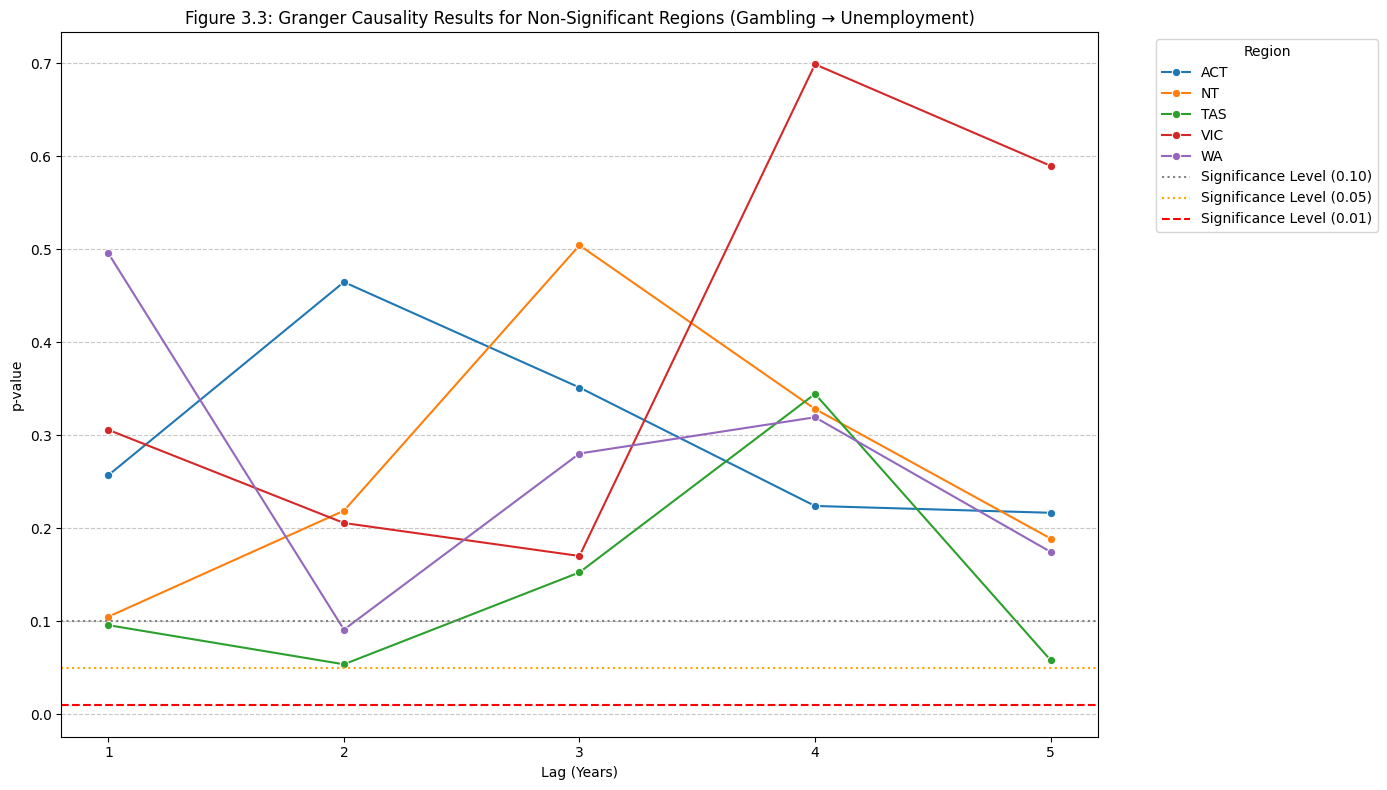

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the combined_gc_all_regions DataFrame for non-significant regions
non_significant_gc_df = combined_gc_all_regions[combined_gc_all_regions['Region'].isin(non_significant_regions_gc)]

plt.figure(figsize=(14, 8))
sns.lineplot(x='Lag', y='p_value', hue='Region', data=non_significant_gc_df, marker='o', palette='tab10')

plt.axhline(0.10, color='grey', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')

plt.title('Figure 3.3: Granger Causality Results for Non-Significant Regions (Gambling → Unemployment)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(non_significant_gc_df['Lag'].unique())
plt.tight_layout()
plt.show()

In [53]:
unique_states = df_flat['State'].dropna().unique()

all_regional_gd_results = []

for state_name in unique_states:
    region_df = df_flat[df_flat["State"] == state_name][
        [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
    ]
    gd_result = granger_unemp_to_gambling_joint(
        region_df,
        year_col=YEAR,
        maxlag=5
    )
    gd_result['Region'] = state_name
    all_regional_gd_results.append(gd_result)




In [54]:
combined_gd_all_regions = pd.concat(all_regional_gd_results, ignore_index=True)
print(combined_gd_all_regions.head())

   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N  \
0    1                       -0.026637  Negative  1.446107  0.243198  25   
1    2                       -0.046703  Negative  2.080705  0.155484  24   
2    3                       -0.077060  Negative  2.301441  0.121724  23   
3    4                       -0.067650  Negative  0.308876  0.866112  22   
4    5                       -0.127726  Negative  0.974296  0.487177  21   

  Region  
0    ACT  
1    ACT  
2    ACT  
3    ACT  
4    ACT  


In [55]:
significant_regions_gd = []
non_significant_regions_gd = []

unique_regions_gd = combined_gd_all_regions['Region'].unique()

for region in unique_regions_gd:
    region_data = combined_gd_all_regions[combined_gd_all_regions['Region'] == region]
    # Check if any p_value for this region is less than 0.05
    if (region_data['p_value'] < 0.05).any():
        significant_regions_gd.append(region)
    else:
        non_significant_regions_gd.append(region)

print(f"Significant Regions (Unemployment -> Gambling, p < 0.05): {significant_regions_gd}")
print(f"Non-Significant Regions (Unemployment -> Gambling, p < 0.05): {non_significant_regions_gd}")

Significant Regions (Unemployment -> Gambling, p < 0.05): ['TAS', 'WA']
Non-Significant Regions (Unemployment -> Gambling, p < 0.05): ['ACT', 'NSW', 'NT', 'QLD', 'SA', 'VIC']


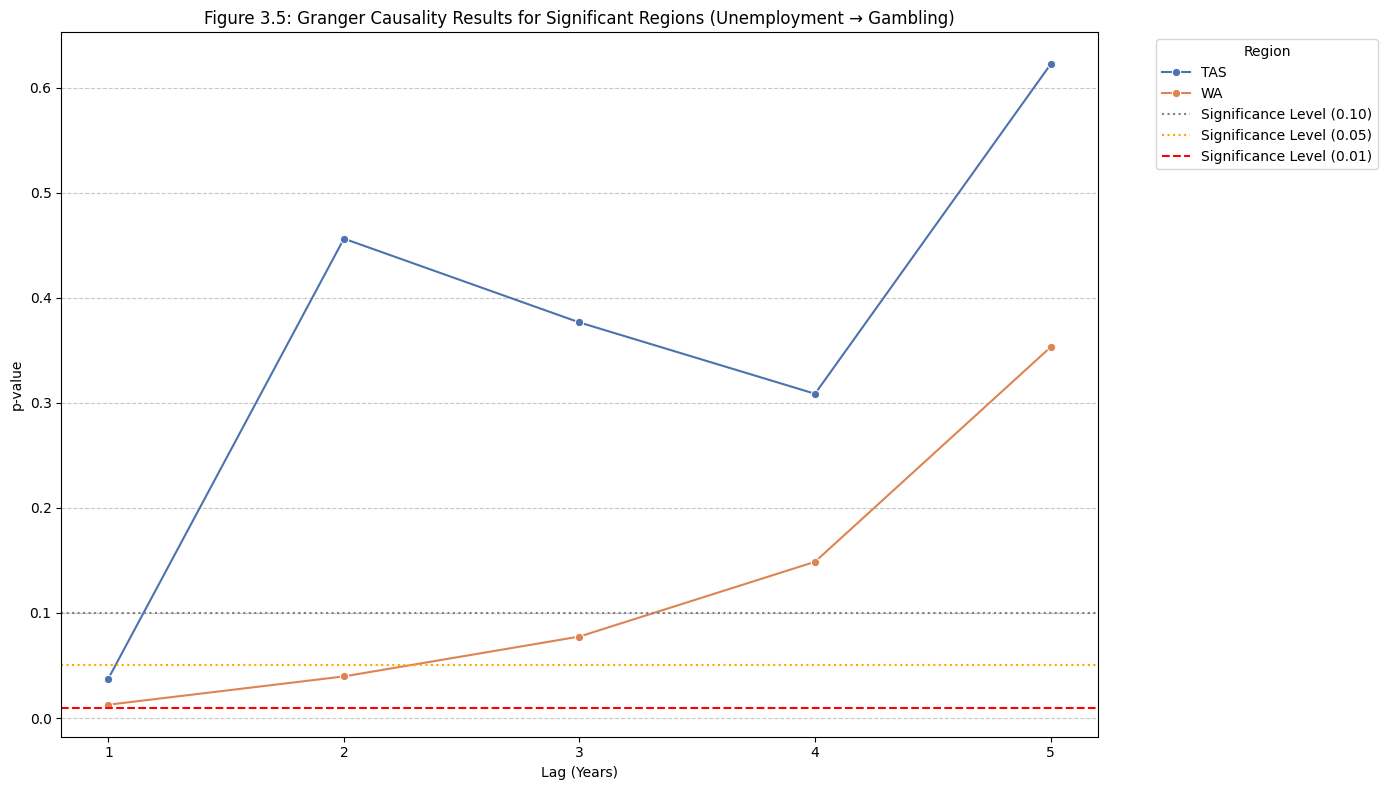

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the combined_gd_all_regions DataFrame for significant regions
significant_gd_df = combined_gd_all_regions[combined_gd_all_regions['Region'].isin(significant_regions_gd)]

plt.figure(figsize=(14, 8))
sns.lineplot(x='Lag', y='p_value', hue='Region', data=significant_gd_df, marker='o', palette='deep')

plt.axhline(0.10, color='grey', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')

plt.title('Figure 3.5: Granger Causality Results for Significant Regions (Unemployment → Gambling)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(significant_gd_df['Lag'].unique())
plt.tight_layout()
plt.show()

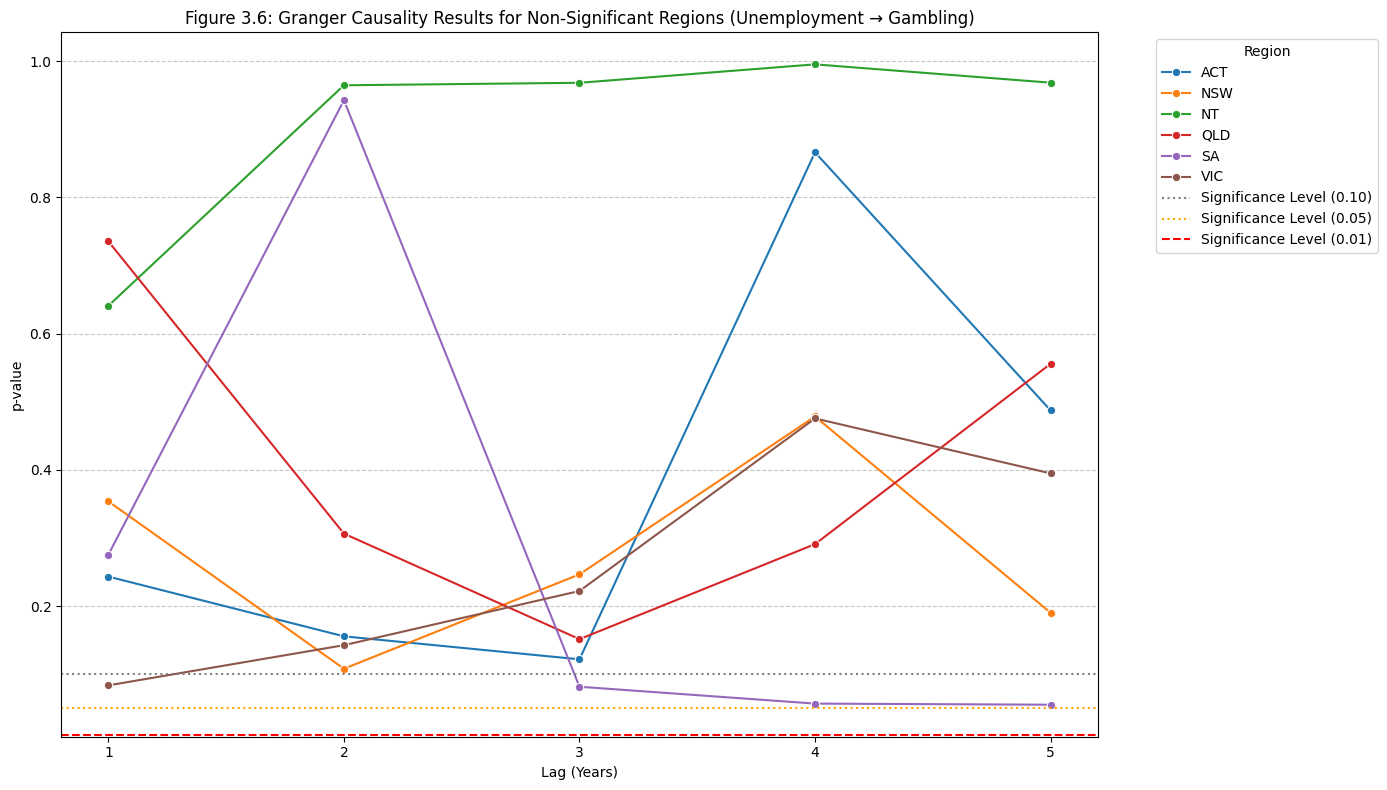

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the combined_gd_all_regions DataFrame for non-significant regions
non_significant_gd_df = combined_gd_all_regions[combined_gd_all_regions['Region'].isin(non_significant_regions_gd)]

plt.figure(figsize=(14, 8))
sns.lineplot(x='Lag', y='p_value', hue='Region', data=non_significant_gd_df, marker='o', palette='tab10')

plt.axhline(0.10, color='grey', linestyle=':', label='Significance Level (0.10)')
plt.axhline(0.05, color='orange', linestyle=':', label='Significance Level (0.05)')
plt.axhline(0.01, color='red', linestyle='--', label='Significance Level (0.01)')

plt.title('Figure 3.6: Granger Causality Results for Non-Significant Regions (Unemployment → Gambling)')
plt.xlabel('Lag (Years)')
plt.ylabel('p-value')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(non_significant_gd_df['Lag'].unique())
plt.tight_layout()
plt.show()